In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 1/2 [02:11<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:12<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:13<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:14<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:15<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:16<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:17<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:19<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:20<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:21<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:22<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:23<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:24<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/2 [02:25<00:14, 14.03s/ url]

Dl Completed...:  50%|█████     | 1/

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\HARI\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys())
for image in dataset['train'].take(1):
    pass
print(image.keys())
print(np.max(image['segmentation_mask'].numpy()))
print(np.min(image['segmentation_mask'].numpy()))

dict_keys(['train', 'test'])


(array([ 55672.,      0.,      0.,      0.,      0., 169695.,      0.,
             0.,      0.,  24633.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

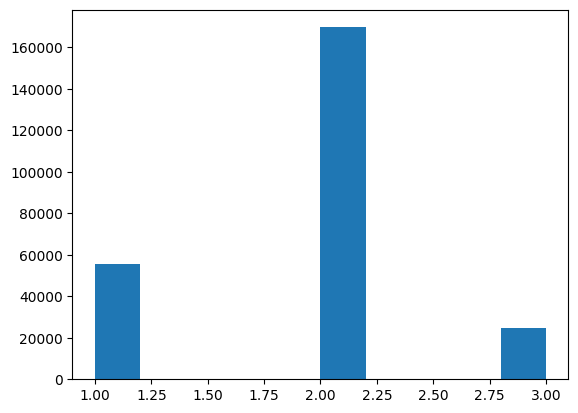

In [9]:
plt.hist(image['segmentation_mask'].numpy().reshape(-1))

In [ ]:
# Preprocessing Utilities
@tf.function
def random_flip(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

@tf.function
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
class_names = ['pet', 'background', 'outline']

def display_with_metrics(display_list, iou_list, dice_score_list):  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)
  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

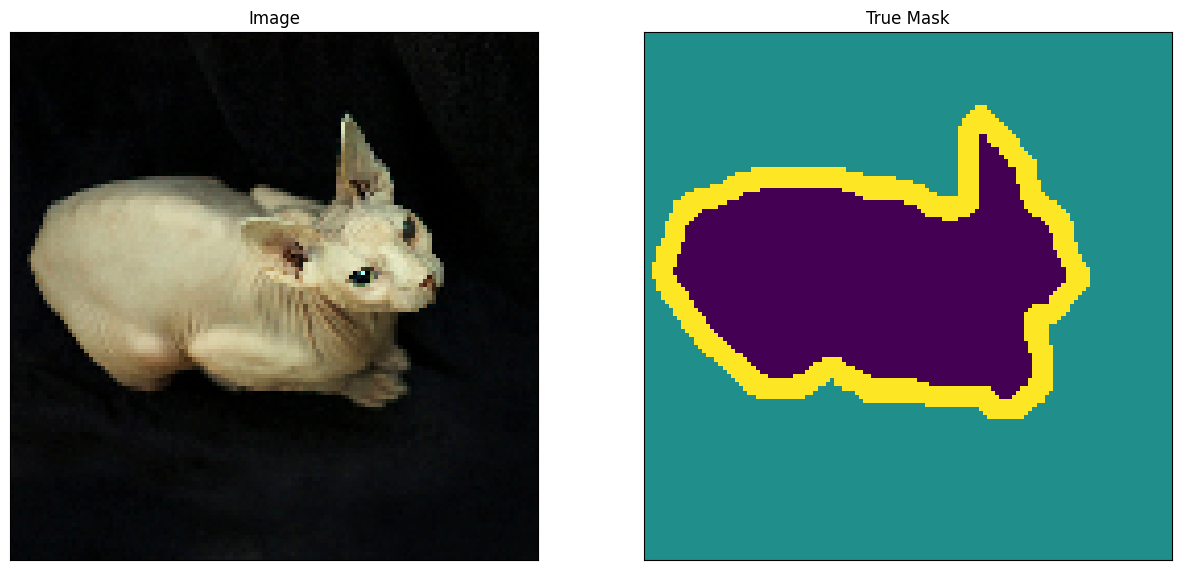

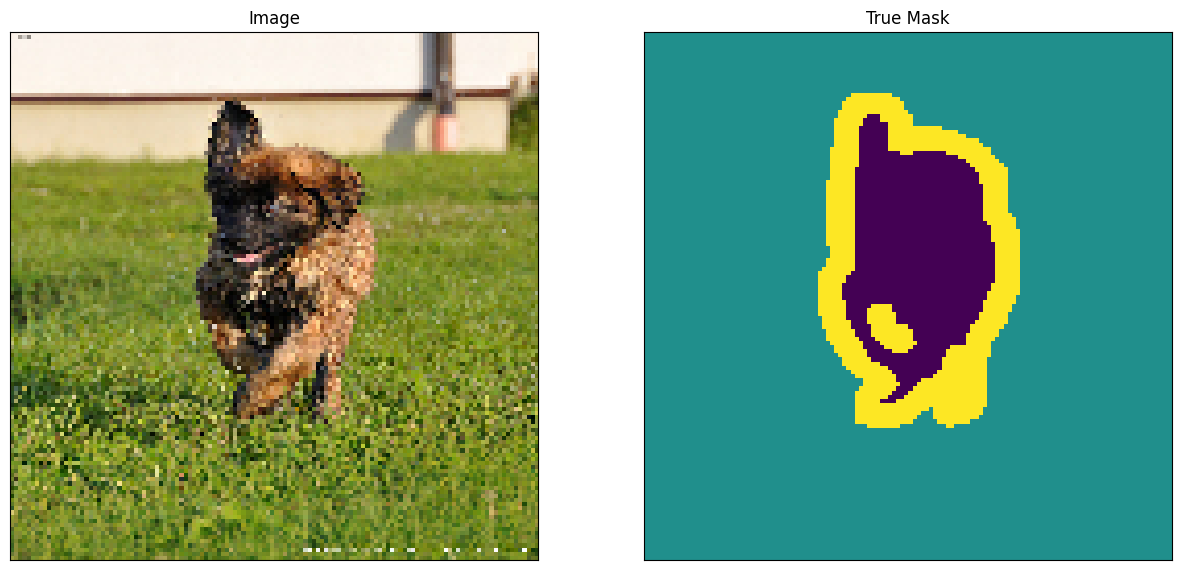

In [ ]:
show_image_from_dataset(train)
show_image_from_dataset(test)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  #Returns:tensor of output features
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)
  return f, p

def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):
  #This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

In [ ]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  #Returns:c (tensor) -- output features of the decoder block
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c


def decoder(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [ ]:
OUTPUT_CHANNELS = 3
def unet():
  #Defines the UNet by connecting the encoder, bottleneck and decoder.
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))
  encoder_output, convs = encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

model = unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv2d_5[0][0]  

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 15
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1504s 26s/step - accuracy: 0.5323 - loss: 1.4109 - val_accuracy: 0.5733 - val_loss: 0.9138
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1556s 28s/step - accuracy: 0.5945 - loss: 0.8758 - val_accuracy: 0.5738 - val_loss: 0.8808
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1497s 26s/step - accuracy: 0.5966 - loss: 0.8432 - val_accuracy: 0.6227 - val_loss: 0.8053
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1454s 26s/step - accuracy: 0.6451 - loss: 0.7836 - val_accuracy: 0.7094 - val_loss: 0.7119
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1590s 28s/step - accuracy: 0.7268 - loss: 0.6749 - val_accuracy: 0.7463 - val_loss: 0.6243
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1519s 27s/step - accuracy: 0.7561 - loss: 0.6120 - val_accuracy: 0.7825 - val_loss: 0.5504
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1517s 27s/step - accuracy: 0.7789 - loss: 0.5622 - val_accuracy: 0.8001 - val_loss: 0.5140
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1479s 26s/step - accuracy: 0.7977 - loss: 0.5179 - val_accu

In [23]:
model.save('Unet.h5')
print('Model is Saved')

Model is Saved


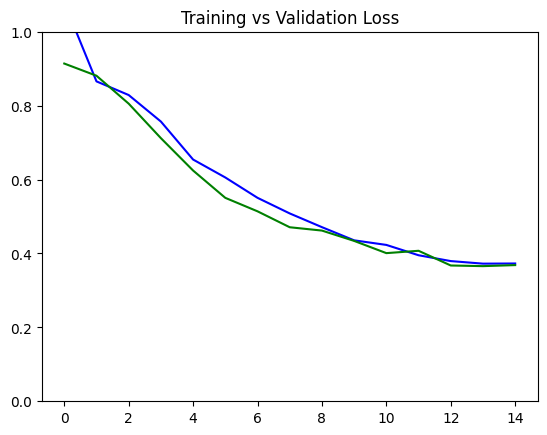

In [22]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [ ]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask 

In [25]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [26]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 ━━━━━━━━━━━━━━━━━━━━ 386s 7s/step


In [27]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [28]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

pet         0.7305955337124332 
background  0.845226314300928 
outline     0.40621728110308264 


In [29]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


pet         0.8443284632144693 
background  0.9161221122312793 
outline     0.5777446864893478 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


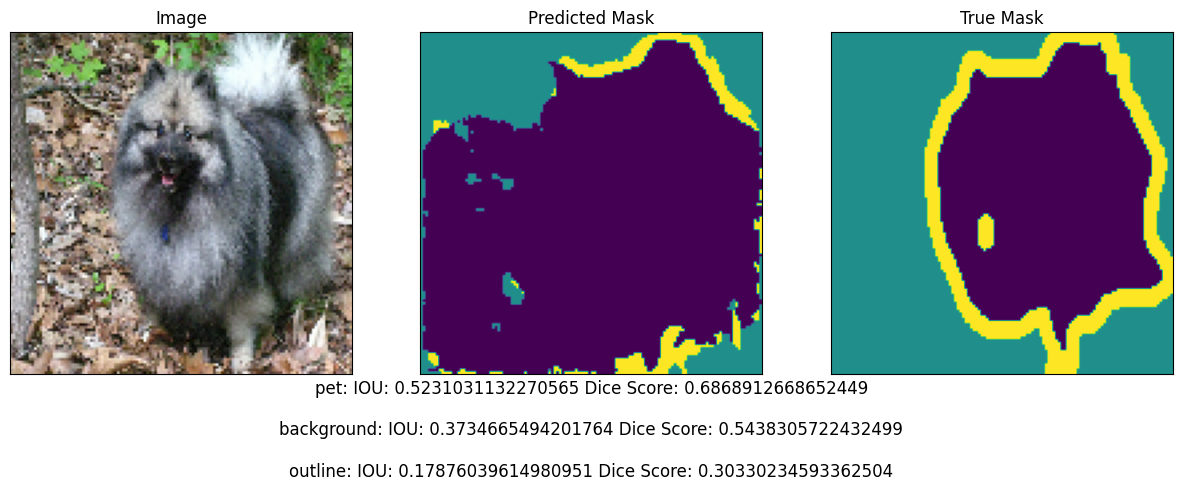

In [32]:
integer_slider = 5
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

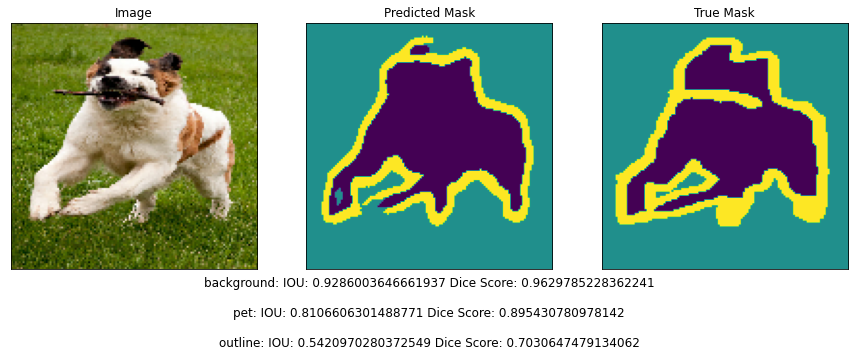

In [ ]:
integer_slider = 2
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

In [1]:
# import cv2

# def segment_video(video_path, output_path):
#     # Open the video file
#     cap = cv2.VideoCapture(video_path)
#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = cap.get(cv2.CAP_PROP_FPS)

#     # Prepare the video writer for saving output
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Resize frame to model input size
#         input_frame = cv2.resize(frame, (128, 128))
#         input_frame = np.expand_dims(input_frame, axis=0)

#         # Generate segmentation mask
#         pred_mask = model.predict(input_frame)
#         pred_mask = create_mask(pred_mask)
        
#         # Resize mask to original frame size and blend with frame
#         mask_resized = cv2.resize(pred_mask, (frame_width, frame_height))
#         colored_mask = (mask_resized * 255).astype(np.uint8)
#         mask_3d = np.repeat(colored_mask, 3, axis=2)  # Convert mask to 3-channel image
#         segmented_frame = cv2.addWeighted(frame, 0.7, mask_3d, 0.3, 0)

#         # Write the segmented frame to the output video
#         out.write(segmented_frame)

#     cap.release()
#     out.release()
#     print("Segmentation complete! Saved to:", output_path)

# # Usage:
# segment_video(r"F:\Sem7\NNDL\Project\videoplayback.mp4", "output_segmented_video.mp4")
